# Estimate Protein Isoelectric Point
Lee Yuan Zhe  
31/12/2021

## 1. Introduction

The isoelectric point of a protein, pI for short, is the pH at which the protein has a net electrical charge of zero. When the pH of the environment is above the pI of a protein, the protein will have a negative net charge. The converse is true when the pH of the environment is below the pI. Hence, knowing the pI of a protein allows us to control the charge of the protein by varying the pH of the environment. With the application of suitable external electric field, it is possible to isolate specific proteins of interest for further experimentation.

In this project, we aim to estimate the pI of various proteins using simple algorithms. Roughly speaking, the algorithms do so by computing the net charge of a protein at various pH values until they find one pH value which gives zero net charge. To gauge the accuracy of our estimation, we compare our calculated pI values with the values available from the [Proteome Isoelecric Point Database](http://isoelectricpointdb2.mimuw.edu.pl/index.html). With coding, we can test our algorithms quickly, allowing for prompt amendments when necessary.

The following modules will be used in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2. pK$_a$ Values of Various Amino Acids

### 2.1 Amino Acids

Each protein is made up of a chain of amino acids. The structure of a neutral amino acid is shown in the figure below.
<img src="amino_acid.png" width="200"/>

Each amino acid has two terminals: the NH$_2$- group forms the N-terminal while the -COOH group forms the C-terminal. The R group is the side chain specific to each amino acid. Two amino acids are linked together when the C-terminal of one amino acid loses an -OH group while the N-terminal of the other amino acid loses an -H to form an amide linkage, represented by -CONH as shown in the figure below.
<img src='amide_linkage.png' width='600'/>
<center><em>The elements in blue are lost by each amino acid during the formation of an amide linkage, shown in red.</em></center>

A protein is formed when many amino acids are linked to each other through amide linkages. Thus, every protein will always have one N-terminal, one C-terminal, and various R groups depending on the amino acids used to from the protein. The N-terminal is basic. It can gain a proton, H$^+$, giving the protein a positive charge. On the other hand, the C-terminal is acidic, which allows it to lose a proton, giving the protein a negative charge. If the R group is basic or acidic, it can also contribute to the protein charge. There are also neutral R groups which will not contribute to the charge of the protein. 

Hence, the overall charge of a protein at a pH is dependent on the charge of its N-terminal, C-terminal, and the various R-groups at that pH.

### 2.2 Acid Dissociation Constant, K$_a$

The strength of an acid is measured by its K$_a$ value, which is a constant. For an acid undergoing the following dissociation in water,
\begin{align}
\text{HA} \rightleftharpoons \text{H}^+ + \text{A}^-
\end{align}
The mathematical definition of K$_a$ is given by:
\begin{equation}
K_a = \frac{[\text{H}^+][\text{A}^-]}{[\text{HA}]}
\tag{1}
\end{equation}

For basic groups, the K$_a$ value gives the strength of the conjugate acid, which is the protonated base. One such example is ammonia as shown below.
\begin{align}
\text{NH}_4^+ \rightleftharpoons \text{H}^+ + \text{NH}_3
\end{align}
\begin{align}
K_a = \frac{[\text{H}^+][\text{NH}_3]}{[\text{NH}_4^+]}
\tag{2}
\end{align}

From the equations, we can infer that the concentration of dissociated acids and protonated bases depends on the respective K$_a$ values and the concentration of protons in the solution. Hence, in order to compute the charge of a protein, we need all the K$_a$ values of all basic and acid groups of every amino acid group making up the protein. We will also need the nature of each R group as this will determine whether it possesses a negative or positive charge.

The values are obtained from [Sigma Aldrich](https://www.sigmaaldrich.com/SG/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart). The chart lists the pK$_a$ values for common amino acids at 25$^{\circ}$C, where pK$_a$ = $-\log$ K$_a$. 'pKa1', 'pKa2', and 'pKa3' give the pK$_a$ values of the C-terminal, N-terminal, and R group respectively.

In [2]:
# Import csv file as data frame.
amino_acid=pd.read_csv('amino_acids_data.csv',index_col='Name')
amino_acid

,Abbr,Symbol,Molecular Weight,Molecular Formula,Residue Formula,Residue Weight (-H2O),pKa1,pKa2,pKa3,pI
Name,,,,,,,,,,
Alanine,Ala,A,89.10,C3H7NO2,C3H5NO,71.08,2.34,9.69,-,6
Arginine,Arg,R,174.20,C6H14N4O2,C6H12N4O,156.19,2.17,9.04,12.48,10.76
Asparagine,Asn,N,132.12,C4H8N2O3,C4H6N2O2,114.11,2.02,8.8,-,5.41
Aspartic acid,Asp,D,133.11,C4H7NO4,C4H5NO3,115.09,1.88,9.6,3.65,2.77
Cysteine,Cys,C,121.16,C3H7NO2S,C3H5NOS,103.15,1.96,10.28,8.18,5.07
Glutamic acid,Glu,E,147.13,C5H9NO4,C5H7NO3,129.12,2.19,9.67,4.25,3.22
Glutamine,Gln,Q,146.15,C5H10N2O3,C5H8N2O2,128.13,2.17,9.13,-,5.65
Glycine,Gly,G,75.07,C2H5NO2,C2H3NO,57.05,2.34,9.6,-,5.97
Histidine,His,H,155.16,C6H9N3O2,C6H7N3O,137.14,1.82,9.17,6,7.59


In [3]:
# Check the data type to confirm whether the entries can be used for calculations later.
amino_acid.dtypes

Abbr                      object
Symbol                    object
Molecular Weight         float64
Molecular Formula         object
Residue Formula           object
Residue Weight (-H2O)    float64
pKa1                      object
pKa2                      object
pKa3                      object
pI                        object
dtype: object

In [4]:
# Replace all missing values with NaN.
amino_acid.replace('-', np.nan, inplace = True)

# Create a dictionary for astype.
data_type = dict(zip(amino_acid.columns.to_list()[-4:], ['float64']*4))

# Change all entries for the last 4 columns to float.
amino_acid = amino_acid.astype(data_type)

# Create a dictionary matching the pKa values of each N-terminal and C-terminal to its respective amino acid.
pKaDict_NH2 = dict(zip(amino_acid['Symbol'], amino_acid['pKa2']))
pKaDict_COOH = dict(zip(amino_acid['Symbol'], amino_acid['pKa1']))

# Select only R groups with pKa values.
R = amino_acid[amino_acid['pKa3'] > 0][['Symbol', 'pKa3']]

# Create a dictionary matching the pKa values of each R group to its respective amino acid.
pKaDict_R = dict(zip(R['Symbol'], R['pKa3']))

# Create a dictionary identifying the nature of the R group of each amino acid: True if acidic, False if basic.
isAcid = {'K':False, 'R':False, 'H':False, 'E':True, 'D':True, 'Y':True, 'C':True}

## 3. Estimating Protein Isoelectric Point

### 3.1 Estimate The Charge of A Protein at Different pH Values

To estimate the charge of a protein, we compute the charge of each R group, N-terminal and C-terminal separately. The final charge of the protein will be the sum of the charges of all groups. The magnitude of the charge is computed from the ratio of the concentration of the dissociated species to the total concentration of the species before dissociation, $\frac{[\text{A}^-]}{[\text{HA}] + [\text{A}^-]}$. For an acid, from equation (1):
\begin{align}
K_a &= \frac{[\text{H}^+][\text{A}^-]}{[\text{HA}]} \\
-\log K_a &= -\log [\text{H}^+] - \log \frac{[\text{A}^-]}{[\text{HA}]} \\
\text{p}K_a &= \text{pH} - \log \frac{[\text{A}^-]}{[\text{HA}]} \\
\log \frac{[\text{A}^-]}{[\text{HA}]} &= \text{pH} - \text{p}K_a \\
\frac{[\text{A}^-]}{[\text{HA}]} &= 10^{\text{pH} - \text{p}K_a} \\
&= r \\
\text{dissociated ratio} &= \frac{r}{r+1} \\
\text{charge} &= - \text{ dissociated ratio}
\end{align}

For a base, we can use the exact steps to arrive at the same expression for the dissociated ratio. However, as seen from equation (2), the charge does not come from the dissociated species but the species before dissociation. The charge is also of opposite sign. Hence,
\begin{align}
\text{charge} &= \frac{[\text{NH}_4^+]}{[\text{NH}_4^+]+[\text{NH}_3]} \\
&= 1 - \text{dissociated ratio}
\end{align}

The mathematical derivations form the basis of the estimateCharge function defined below. In all our following calculations, we assume that the proteins are in water of 25$^{\circ}$C. We also ignore the effect of neighbouring amino acids on the dissociation constants of each component amino acid. In reality, the pK$_a$ values depend on how the component amino acids interact with each other.

In [5]:
def estimateCharge(sequence, pH):
    """Use pKa values to estimate the charge of a sequence of amino acids at a given pH"""
    
    # Starting value for the net charge of protein.
    total = 0.0
    
    # By convention, the first letter of an amino acid sequence is the N-terminal. We begin by obtainning the pKa value of the 
    # N-terminal of the first amino acid by using the dictionary built earlier. The charge is computed from the pKa value using 
    # the derivation shown earlier.
    pKaN = pKaDict_NH2.get(sequence[0])
    rN = 10.0 ** (pH - pKaN)
    dissociatedN = rN / (rN + 1.0)
    chargeN = 1.0 - dissociatedN
    
    # Update the net charge of protein with the charge from the N-terminal.
    total += chargeN
    
    # Loop over the entire sequence to compute the charge due to each R group.
    for aminoAcid in sequence:
        
        # Obtain the pKa value of the R group from the dictionary built earlier.
        pKaR = pKaDict_R.get(aminoAcid)
        
        # Check whether the R group is neutral. If it is not, calculate the dissociated ratio.
        if pKaR is not None:
            rR = 10.0 ** (pH - pKaR)
            dissociatedR = rR / (rR + 1.0)
            
            # Check whether the R group is acidic or basic. Calculate the charge accordingly.
            if isAcid[aminoAcid]:
                chargeR = -1.0 * dissociatedR
            else:
                chargeR = 1.0 - dissociatedR
            
            # Update the net charge of protein with the charge of the R group.
            total += chargeR
    
    # Obtain the pKa value of the C-terminal using the dictionary built earlier, followed by charge calculation.
    pKaC = pKaDict_COOH.get(sequence[-1])
    rC = 10.0 ** (pH - pKaC)
    dissociatedC = rC / (rC + 1.0)
    chargeC = -1.0 * dissociatedC
    
    # Update the net charge of protein with the charge of the C-terminal.
    total += chargeC
    return total

With the estimateCharge function, we can compute the charge of the protein at every pH value. By running the function through a loop where the pH value of each iteration differs from the next by a small amount, we can find the pH value which gives the charge which is closest to zero. This gives us the estimated pI value of the protein. However, this exhaustive method takes too many steps. Hence, we will employ an optimisation algorithm to find the pI value.

### 3.2 Optimisation Algorithm

To come up with an effective optimisation algorithm, we analyse how the charge of an example sequence, ARN, varies with pH.

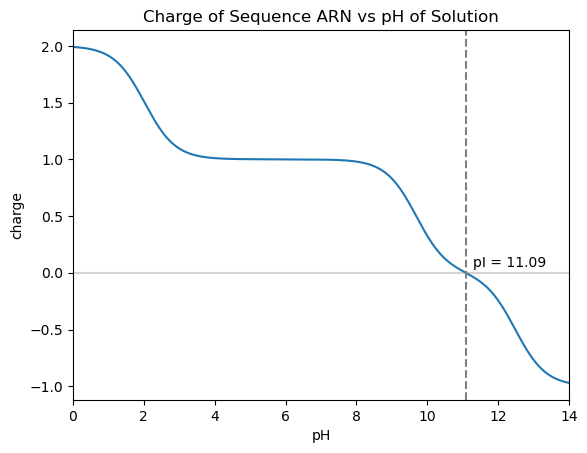

In [6]:
# Generating an array of x-coordinates, pH.
pH_x = np.arange(0, 14.01, 0.01)

# Generating an array of y-coordinates, charge.
charge_y = estimateCharge('ARN', pH_x)

# Finding the pH value which gives the charge closest to zero.
pI = pH_x[np.argmin(abs(charge_y))]

# Plot a graph of charge vs pH.
plt.plot(pH_x, charge_y)
plt.xlabel('pH')
plt.ylabel('charge')
plt.axhline(0, zorder = -1, color = 'lightgray')
plt.axvline(pI, zorder = 2, color = 'gray', linestyle = '--')
plt.text(pI + 0.2, 0.05, 'pI = {:.2f}'.format(pI))
plt.title('Charge of Sequence ARN vs pH of Solution')
plt.xlim(0, 14)
plt.show()

The general idea of the estimateIsoelectric function shown below is to estimate the charge of the protein at various pH values until we encounter one where the magnitude of the net charge is less than the threshold value, delta. The threshold value is $1 \times 10^{-5}$ by default, but can be adjusted depending on the error tolerance. 

The key feature differentiating the estimateIsoelectric function from the exhaustive method is the manner in which the pH values are chosen. If the magnitude of the charge of the protein at a tested pH value is greater than the threshold, the function needs to find a new pH value to be tested. If the starting test pH is 0.0, based on the graph above, we can see that the new test pH should be an increment of the old test pH to bring the charge closer to 0. Since the average proteome isoelectric point of most organisms is around 7 (source: [Proteome Isoelecric Point Database](http://isoelectricpointdb2.mimuw.edu.pl/index.html)), we fix the increment to be 7.0 by default, but adjustable depending on the proteome tested. If the new test pH is a better guess of pI (i.e. the pH gives a magnitude of charge which is closer to 0), we keep the same increment step when searching for the new test pH. 

If the new test pH is a worse guess, by inspecting the graph above, we know that our new test pH have overshot the pI value. Hence, we reduce the increment step by half to get our next test pH. The graph also implies that the increment should be negative when the charge is negative to bring the charge closer to 0.

Admittedly, the scale of this project, and others in SP2273, is small enough such that there're not much added benefits in favour of the optimisation algorithim compared to the exhaustive method. Nonetheless, coming up with intelligent optimisation is a good habit to cultivate, especially when you deal with larger scale problems in your computing journey beyond SP2273. You may refer to the appendix for a numerical comparison between the optimisation algorithm and the exhaustive method.

In [7]:
def estimateIsoelectric(chargeFunction, sequence, increment = 7.0, threshold = 1e-5):
    """Estimate the pI of a protein sequence."""
    
    # In case the sequence is not a string.
    sequence = str(sequence)
    
    # Starting test pH value, and the function used to compute protein charge.
    best_pI = 0.0
    minCharge = chargeFunction(sequence, best_pI)
    
    # The loop only stops when the charge of the protein is less than the threshold value.
    while abs(minCharge) > threshold:
        
        # Compute the new test pH, and the protein charge of the new test pH.
        pHtest = best_pI + increment
        charge = chargeFunction(sequence, pHtest)
        
        # Steps if the new test pH is a better guess than the old test pH.
        if abs(charge) < abs(minCharge):
            
            # Update protein charge.
            minCharge = charge
            
            # Update the best guess pI value.
            best_pI = pHtest
        
        # Steps if the new test pH is a worse guess than the old test pH.
        else:
            
            # Half the increment step to prevent overshooting.
            increment = abs(increment) / 2.0
            
            # Reverse the direction of increment if the protein charge is negative.
            if minCharge < 0.0:
                increment *= -1
                
    return best_pI

### 3.3 Testing Algorithim on Amino Acids

Before testing our algorithm against proteome database, we first start testing on individual amino acids.

In [8]:
# Add a new column to the amino acid dataframe, listing all the estimated pI values.
predicted_pI = []
for i in amino_acid['Symbol']:
    predicted_pI.append(round(estimateIsoelectric(estimateCharge, i), 2))
amino_acid['calculated pI'] = predicted_pI

# Add a new column to the amino acid dataframe, listing the percentage difference between the estimated and actual pI values.
amino_acid['percentage difference'] = round((amino_acid['pI'] - amino_acid['calculated pI']) / amino_acid['pI'] * 100, 1)

# Load only columns of interest from the modified amino acid dataframe.
amino_acid.loc[:, 'pKa1':]

,pKa1,pKa2,pKa3,pI,calculated pI,percentage difference
Name,,,,,,
Alanine,2.34,9.69,NaN,6.00,6.02,-0.3
Arginine,2.17,9.04,12.48,10.76,10.76,0.0
Asparagine,2.02,8.80,NaN,5.41,5.41,0.0
Aspartic acid,1.88,9.60,3.65,2.77,2.77,0.0
Cysteine,1.96,10.28,8.18,5.07,5.07,0.0
Glutamic acid,2.19,9.67,4.25,3.22,3.22,0.0
Glutamine,2.17,9.13,NaN,5.65,5.65,0.0
Glycine,2.34,9.60,NaN,5.97,5.96,0.2
Histidine,1.82,9.17,6.00,7.59,7.59,0.0


We can see from the dataframe above that our algorithm performs admirably well. With the exception of the two amino acids with missing pK$_a$ or pI values, our algorithm managed to calculate the pI values of all amino acids to within 4% of the actual values. 

We are now ready to test our algorithm on proteome database.

### 3.4 Testing Algorithm on E. Coli Proteome

The pI values of E.coli Proteome as obtained from the [Proteome Isoelecric Point Database](http://isoelectricpointdb2.mimuw.edu.pl/index.html) are calculated using 21 algorithms. We will compare our algorithms against the average of the 21 algorithms. We consider our algorithim to be accurate if our estimation lies within one standard deviation from the mean.

In [9]:
# Import the proteome database as dataframe, including only columns relevant to pI calculation.
ecoli = pd.read_csv('ecoli_isoelectric.csv', usecols = range(24))
ecoli

,header,seq,mass,Bjellqvist,DTASelect,Dawson,EMBOSS,Grimsley,IPC2_peptide,IPC2_protein,...,Patrickios,ProMoST,Rodwell,Sillero,Solomon,Thurlkill,Toseland,Wikipedia,IPC2.protein.svr19,IPC2.peptide.svr19
0,sp|P06960|OTC2_ECOLI Ornithine carbamoyltransf...,MATLKDIAIEAGVSLATVSRVLNDDPTLNVKEETKHRILEIAEKLE...,36210.35904,5.690,6.020,5.639,5.893,5.881,5.944,5.499,...,4.215,5.753,5.601,5.944,5.639,5.931,5.766,5.588,5.510,5.936
1,sp|P06993|MALT_ECOLI HTH-type transcriptional ...,MSDLYKKHFLKLLDFTPAQFTSLLTLAAQLKADKKNGKEVQKLTGK...,36827.14434,5.626,5.944,5.563,5.804,5.792,5.868,5.410,...,4.240,5.563,5.525,5.868,5.563,5.855,5.690,5.512,5.468,5.866
2,sp|P07639|AROB_ECOLI 3-dehydroquinate synthase...,MLIPSKLSRPVRLDHTVVRERLLAKLSGANNFRLALITSPAGYGKT...,103118.45694,6.033,6.491,6.020,6.465,6.440,6.415,5.677,...,4.279,6.109,6.008,6.402,6.020,6.504,6.249,6.033,5.821,6.299
3,sp|P08191|FIMH_ECOLI Type 1 fimbrin D-mannose ...,MERIVVTLGERSYPITIASGLFNEPASFLPLKSGEQVMLVTNETLA...,38880.98884,5.715,6.046,5.664,5.931,5.855,5.982,5.537,...,4.202,5.779,5.639,5.982,5.664,5.970,5.766,5.626,5.519,5.975
4,sp|P09831|GLTB_ECOLI Glutamate synthase [NADPH...,MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...,31473.48884,7.585,7.732,7.658,7.878,6.561,7.293,6.795,...,0.502,7.190,7.629,8.053,7.775,7.761,6.576,7.585,7.530,7.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4445,sp|P15005-2|MCRB-2_ECOLI Isoform of P15005 Is...,MNIFKPISYIASLAPREVTLLALV,2660.25364,8.346,8.829,9.063,9.297,8.887,7.995,7.732,...,7.614,8.463,9.019,9.019,9.721,8.858,9.107,9.180,8.273,8.273
4446,sp|P63284-2|CLPB-2_ECOLI Isoform of P63284 Is...,MSKTESYCLEDALNDLFIPETTIETILKRLTIKKNIILQGPPGVGK...,34659.50584,5.258,5.359,5.130,5.016,4.991,5.308,5.245,...,4.037,5.270,5.041,5.321,5.118,5.067,5.080,4.978,5.123,5.123
4447,sp|P75960-2|NPD-2_ECOLI Isoform of P75960 Iso...,MNDQGAEDQRQALKKYTIDLTERAEQGKLDPVIGRDEEIRRTIQVL...,79870.23204,5.410,5.563,5.308,5.258,5.270,5.525,5.308,...,4.495,5.436,5.245,5.525,5.308,5.321,5.321,5.169,5.326,5.326
4448,sp|Q59385-2|COPA-2_ECOLI Isoform of Q59385 Is...,MEKPRVLVLTGAGISAESGIRTFRAADGLWEEHRVEDVATPEGFDR...,26716.38314,5.423,5.703,5.359,5.512,5.512,5.652,5.245,...,4.012,5.474,5.308,5.639,5.359,5.575,5.461,5.283,5.293,5.293


In [10]:
# Add new columns to the ecoli dataframe, showing the mean and standard deviation of pI values obtained from 21 algorithms. 
ecoli['average pI'] = [round(ecoli.iloc[i, 3:].mean(), 2) for i in range(ecoli.shape[0])]
ecoli['standard deviation'] = [round(ecoli.iloc[i, 3:23].std(), 2) for i in range(ecoli.shape[0])]

In [11]:
def within_range(chargeFunction):
    """Check whether the estimated pI value is within one standard deviation from the mean for each sequence."""
    
    # Add a new column to the ecoli dataframe, listing all the estimated pI values.
    predicted_ecoli_pI = []
    for i in ecoli['seq']:
        predicted_ecoli_pI.append(round(estimateIsoelectric(chargeFunction, i), 2))
    ecoli['calculated pI'] = predicted_ecoli_pI
    
    # Add a new column to the ecoli dataframe, listing whether the estimated pI value is within one sd from the mean.
    ecoli['within range?'] = ecoli.apply(lambda x: 
                                   True if x['calculated pI'] >= x['average pI'] - x['standard deviation'] 
                                   and x['calculated pI'] <= x['average pI'] + x['standard deviation'] else False, axis = 1)
    
    # Show only the sequence where the estimated pI value lies more than one sd from the mean.
    return ecoli[ecoli['within range?'] == False].loc[:, 'average pI':]

In [12]:
within_range(estimateCharge)

,average pI,standard deviation,calculated pI,within range?
46,4.70,0.14,4.54,False
271,10.77,0.51,11.29,False
340,4.31,0.15,4.11,False
365,10.68,0.49,11.18,False
416,4.51,0.14,4.35,False
...,...,...,...,...
4421,8.97,0.61,9.64,False
4427,4.34,0.28,3.96,False
4428,8.79,0.61,9.54,False
4433,8.95,0.62,9.64,False


From here, we can see that despite ignoring the effect of changing pK$_a$ values, our algorithm performs surprisingly well. Out of 4450 proteins, only 100 of them has pI values lying outside the acceptable range.

Next, we attempt to improve the accuracy of our algorithm by considering the effect of varying pK$_a$ values due to neighbouring amino acids. Our goal is to have less than 100 proteins with pI values lying outside the acceptable range.

### 3.5 Consider the effect of varying dissociation constants of termini

The R groups can be categorised into two groups: electron withdrawing group and electron donating group. Like the name suggests, an electron withdrawing group reduces the electron density of neighbouring groups. This causes deprotonated C-terminal to be more stable as the deprotonated C-terminal becomes less negatively charged. This causes the C-terminal to have a higher tendency to get deprotonated, making it a stronger acid, resulting in a lower pK$_a$ value. An electron withdrawing group also causes a protonated N-terminal to become less stable as the protonated N-terminal becomes more positively charged. This causes the protonated N-terminal to have a higher tendency to lose a proton, also resulting in a lower pK$_a$ value. An electron donating group has the opposite effect on both C-terminal and N-terminal.

With this knowledge, we will be modifying the pK$_a$ values of the C- and N-termini of a protein depending on the type of R groups making up the sequence. All we need is to figure out whether each R group is electron withdrawing or electron donating. While it is technically possible to study each R group one-by-one manually, we shall make use of the amino acid data frame to help us decide quickly.

The figure below shows the structural formula of a glycine.
<img src='gly.gif' width='200'/>

The figure shows that the R group of glycine is H, which is regarded as the standard and has no electron withdrawing or donating effect. Hence, we use the pK$_a$ value of the C-terminal of glycine, 2.34 as a gauge on whether the R group of an amino acid is electron withdrawing or donating. If the pK$_a$ value of the C-terminal of an amino acid is less than 2.34, it means that the deprotonated C-terminal is more stable, implying that the R group is an electron withdrawing group. If the pK$_a$ value is more than 2.34, the R group is an electron donating group. If the pK$_a$ value is exactly 2.34, the R group has no effect on neighbouring groups.

With this, we build a dictionary to capture the electron donating and withdrawing property of each R group. For simplicity, we assume that all R groups will cause a change of 0.5 in the pK$_a$ value of its immediate neighbour. Since both the C- and N-termini experience the same direction of change in pk$_a$ value, we will also assume that each R group will cause the same change in both C- and N-terminal.

In [13]:
fixValue = []

# Extract the pKa value of the C-terminal of an amino acid.
for i in amino_acid['pKa1']:
    
    # Check if the R group is electron withdrawing.
    if i < 2.34:
        fixValue.append(-0.5)
    
    # Check if the R group is electron donating.
    elif i > 2.34:
        fixValue.append(0.5)
    
    # If the R group is neutral.
    else:
        fixValue.append(0)

# Key: Amino acid, Value: assumed change in pKa value
pKafixed = dict(zip(amino_acid['Symbol'], fixValue))

With the dictionary, we will now make a new function to estimate the charge of a protein at various pH values, estimateCharge2. For the most parts, this function is the same as estimateCharge, with the addition of new lines to amend the pK$_a$ values of the C- and N-terminal before calculating their respective charges. Since we expect the effect of each R group on a terminal to be weaker if the R group is further from the terminal, a simple weighing function is introduced when computing the change. The default change of 0.5 is divided by the distance of the amino acid from the terminal.

In [14]:
def estimateCharge2(sequence, pH):
    """Use pKa values to estimate the charge of a sequence of amino acids at a given pH.
    Take into account the effect of the immediate neighbour of the C-terminus."""
    total = 0.0
    pKaN = pKaDict_NH2.get(sequence[0])
    
    # Consider the effect of all R groups starting from the second amino acid.
    for i in range(1, len(sequence)):
        
        # Obtain the unweighted change in pKa value associated to the R group.
        fixedN = pKafixed.get(sequence[i])
        
        # In case the amino acid is not among the ones listed in the amino_acid data frame.
        if fixedN is not None:
            
            # Change the pKa value of the N-terminal, weighted by the distance from ther terminal.
            pKaN += fixedN / i
            
    rN = 10.0 ** (pH - pKaN)
    dissociatedN = rN / (rN + 1.0)
    chargeN = 1.0 - dissociatedN
    total += chargeN
    for aminoAcid in sequence:
        pKaR = pKaDict_R.get(aminoAcid)
        if pKaR is not None:
            rR = 10.0 ** (pH - pKaR)
            dissociatedR = rR / (rR + 1.0)
            if isAcid[aminoAcid]:
                chargeR = -1.0 * dissociatedR
            else:
                chargeR = 1.0 - dissociatedR
            total += chargeR
    pKaC = pKaDict_COOH.get(sequence[-1])
    
    # Consider the effect of all R groups starting from the second amino acid counting from the right.
    for i in range(-2, -1*len(sequence)-1, -1):
        
        # Obtain the unweighted change in pKa value associated to the R group.
        fixedC = pKafixed.get(sequence[i])
        
        # In case the amino acid is not among the ones listed in the amino_acid data frame.
        if fixedC is not None:
            
            # Change the pKa value of the C-terminal, weighted by the distance from ther terminal.
            pKaC += fixedC / (i * (-1) - 1)
    
    rC = 10.0 ** (pH - pKaC)
    dissociatedC = rC / (rC + 1.0)
    chargeC = -1.0 * dissociatedC
    total += chargeC
    return total

In [15]:
within_range(estimateCharge2)

,average pI,standard deviation,calculated pI,within range?
46,4.70,0.14,4.54,False
340,4.31,0.15,4.11,False
365,10.68,0.49,11.18,False
416,4.51,0.14,4.35,False
511,4.17,0.16,4.00,False
...,...,...,...,...
4403,4.28,0.21,3.95,False
4412,3.79,0.57,2.91,False
4413,4.80,0.16,4.59,False
4421,8.97,0.61,9.66,False


Previously, without considering the effect of R groups, the pI values of 100 proteins out of 4450 is more than one sd from the mean. By using a simple algorithm to consider the effect of R groups on the pK$_a$ values of the C- and N-terminal, only 75 proteins fall outside the range. This shows that our simple algorithm does improve the estimation of the protein pI values.

## 4. Future Work

For those interested in picking up this project, the following are three possible avenues you can work on:
1) Explore ways to more accurately reflect the changes in pK$_a$ values due to neighbouring amino acids.  
2) Consider the effect of protein folding on the pK$_a$ values of component amino acids. This effect has been ignored throughout this notebook.  
3) Study why the algorithm used in this notebook worked as well as it did. Like holy @#$%! I myself am damn surprised by how accurate this is. o_O

## 5. Appendix

Here, we make a comparison between the time needed to execute to estimate the pI values using the exhaustive method and the optimisation algorithm. As usual, Python already has a module for that. We will use the 'ARN' sequence as an example.

In [16]:
from timeit import default_timer as timer

In [19]:
start = timer()
pH_x = np.arange(0, 14.01, 0.01)
charge_y = estimateCharge('ARN', pH_x)
pI = pH_x[np.argmin(abs(charge_y))]
end = timer()
time_diff = end - start
print('The pI value of {0:.2f} is obtained in {1:.2e} seconds'.format(pI, time_diff))

The pI value of 11.09 is obtained in 1.29e-03 seconds


In [18]:
start = timer()
pI = estimateIsoelectric(estimateCharge, 'ARN')
end = timer()
time_diff = end - start
print('The pI value of {0:.2f} is obtained in {1:.2e} seconds'.format(pI, time_diff))

The pI value of 11.09 is obtained in 1.92e-04 seconds


Both methods give us the same pI value. However, the optimisation algorithm does so in approximately one-tenth of the time taken by the exhaustive method. The difference is not significant for a small scale project such as this. But once the project turns large scale, the time saved will become significant.